## Introduction

### Gene Expression Cancer RNA-Seq Dataset

**Source**: UCI Machine Learning Repository

**Description**: This dataset comprises RNA-Seq gene expression profiles from patients with different types of tumors. It is used for the classification of cancer types based on gene expression patterns.

**Contents**:
- **Samples**: The dataset includes samples from patients with various forms of tumors.
- **Features**: Gene expression levels, represented numerically, are the primary features in this dataset.
- **Applications**: Ideal for training machine learning models to classify types of cancer. Also useful for exploratory data analysis in cancer genomics.

**Usage**: This dataset serves as a foundational tool for understanding cancer genomics, enabling the development and testing of algorithms for cancer classification based on gene expression data.

**Webpage**: [Gene Expression Cancer RNA-Seq Dataset](https://archive.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq)

## Imports

In [41]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

## Read Dataset

In [26]:
# Read features
X = pd.read_csv("data/data.csv", index_col=[0])
X.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [27]:
# Read labels
y = pd.read_csv("data/labels.csv", index_col=[0])
y.head()

,Class
sample_0,PRAD
sample_1,LUAD
sample_2,PRAD
sample_3,PRAD
sample_4,BRCA


### Preprocessing

In [28]:
# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

In [29]:
# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.values.ravel())

In [30]:
# Sanity check
y_decoded = label_encoder.inverse_transform(y_encoded)
all(y_decoded == y.values.ravel())

True

### Splits

In [31]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

In [32]:
# Splitting data into train and test sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

### Neural Network

In [33]:
num_input_features = X_tensor.shape[1]
num_classes = len(y_tensor.unique())
print(f"Number of input features: {num_input_features}")
print(f"Number of classes: {num_classes}")

Number of input features: 20531
Number of classes: 5


In [34]:
# Neural Network Class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_input_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [35]:
net = Net()
if torch.cuda.is_available():
    net.cuda()

### Training

In [36]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [37]:
# Training the Model
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in DataLoader(train_dataset, batch_size=32):
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/10, Loss: 0.00018253058078698814
Epoch 2/10, Loss: 2.7586207579588518e-05
Epoch 3/10, Loss: 4.632771742762998e-05
Epoch 4/10, Loss: 6.601764471270144e-05
Epoch 5/10, Loss: 3.688883953145705e-05
Epoch 6/10, Loss: 2.31406775128562e-05
Epoch 7/10, Loss: 1.677069849392865e-05
Epoch 8/10, Loss: 1.317002625000896e-05
Epoch 9/10, Loss: 1.083141251001507e-05
Epoch 10/10, Loss: 9.185338967654388e-06


### Evaluate

In [39]:
# Evaluate the Model
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size=32):
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 100.00%


### Hierarchical Clustering

In hierarchical clustering, a dendrogram is a tree-like diagram that records the sequences of merges or splits. The main components of a dendrogram are:

1. **Leaves**: Each leaf represents one of thpacients.e.

2. **Branches**: These represent the clusters formed. The height at which branches merge in the dendrogram reflects the similarity between clusters: lower height means higher similarity.

3. **Root**: The top of the dendrogram represents the final single cluster that aggregates all data points.

In essence, the dendrogram visually shows at what level of similarity any two clusters were merged (for agglomerative clustering) or where a single cluster was split (for divisive clusrofiles.

In [42]:
# Extract Features for Clustering
def extract_features(model, dataset):
    model.eval()
    features = []
    with torch.no_grad():
        for inputs, _ in DataLoader(dataset, batch_size=32):
            if torch.cuda.is_available():
                inputs = inputs.cuda()
            outputs = model.fc2(model.fc1(inputs))  # Extracting from second last layer
            features.append(outputs.cpu().numpy())
    return np.concatenate(features, axis=0)

features = extract_features(net, test_dataset)

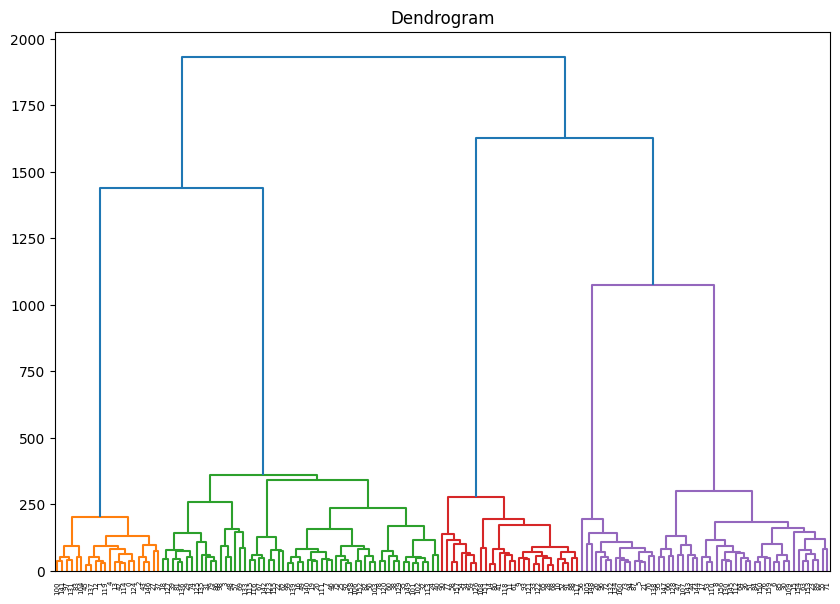

In [43]:
# Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(features, 'ward')
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram(Z)
plt.show()